# <span style='font-family:Georgia'> Index Deep Dive

In [8]:
from primitive import *

In [9]:
index_name = 'dow_jones'
df = get_dow_jones()
dj = df.loc[:, index_name]
dj_ret = dj.pct_change()
dj_log_ret = np.log(dj) - np.log(dj.shift(1))

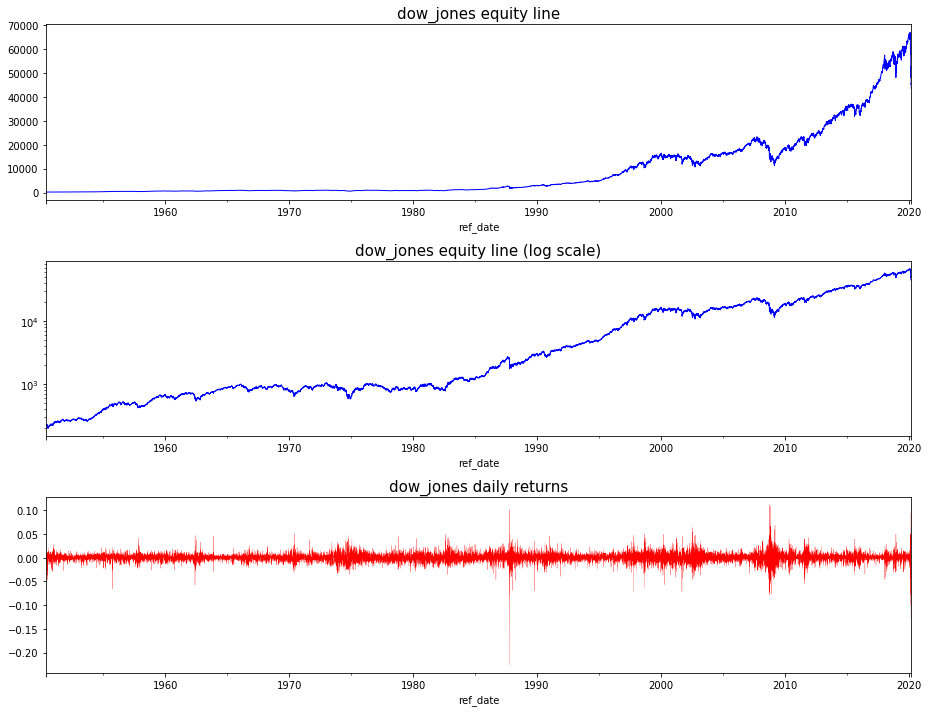

In [10]:
fig = plt.figure(figsize=(13, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title(index_name + ' equity line', fontsize=15)
ax2.set_title(index_name + ' equity line (log scale)', fontsize=15)
ax3.set_title(index_name + ' daily returns', fontsize=15)
dj.plot(ax=ax1, color='blue', linewidth=1)
dj.plot(ax=ax2, color='blue', linewidth=1, logy=True)
dj_ret.plot(ax=ax3, color='red', linewidth=0.2)
plt.tight_layout()
plt.show()

## <span style='font-family:Georgia'> Log-log vs semi-log plot

- All equations of the form: $y = a^x$ form a straight lines when plotted semi-logarithmical graph. Taking the log on both sides,

  $$
  \log_{a}(y) = \log_{a}(a^x)
  $$
  
  hence, $\log_{a}(y) = x + \log(c)$; setting $\log(c) = k$, we obtain $\log_{a}(y) = x + k$; then is a linear function of $x$


- Relations of the form $y= x^k$ appear as straight lines in a log–log graph. Taking the log on both sides, 
  
  $$
  \log(y) = \log(x^\alpha)
  $$
  
  hence, $\log(y) = \alpha \log(x)$; setting $\log(y) = Y$ and $\log(x) = X$, we obtain $Y = \alpha X$
  
Then, if plotting the tail of the return distribution on a log log plot resemble a straight line, we can't rule out the possibility hat data come from a power law distribution.

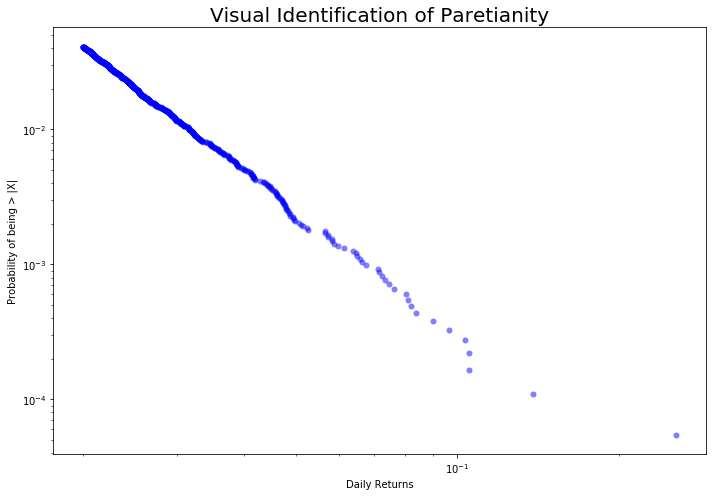

In [11]:
log_log_plot_with_threshold(dj_log_ret, threshold=0.02)

## <span style='font-family:Georgia'> Kurtosis Analysis

Relying on the non-convergence of moments, let $\lVert X_p \lVert$ be the weighted p-norm

$$
\lVert X_p \lVert \triangleq (\frac{1}{n} \sum_{i=1}^{n}||x||_p)^\frac{1}{p}
$$

we have the property of power laws $E(Xp) ≮  \infty \Leftrightarrow ∥x∥_p$ is not convergent. First, let's check if the fourth moment of the daily returns are converging.

In [12]:
kurt_original = pd.Series(lagging_kurtosis(dj.reset_index().loc[:, 'dow_jones']))

kurt_dict_reshuffled = {}
for k in range(10):
    dj_reshuffled = reshuffled_ts(dj)
    kurt_dict_reshuffled[k] = lagging_kurtosis(dj_reshuffled)

kurt_reshuffled = pd.DataFrame(kurt_dict_reshuffled).mean(axis=1)

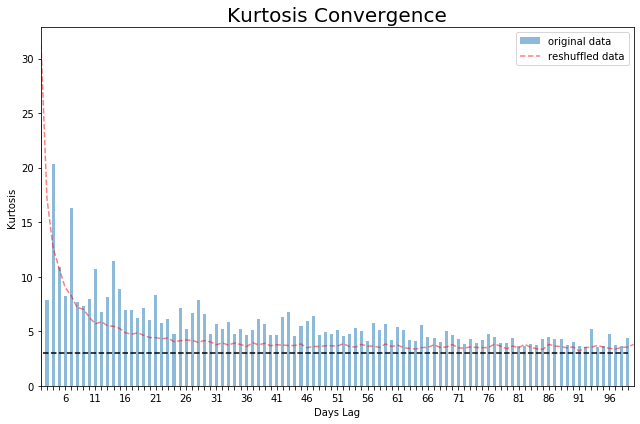

In [13]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
kurt_reshuffled.name = 'reshuffled data'
kurt_original.name = 'original data'
kurt_original.plot(kind='bar', ax=ax, alpha=0.5,  legend=True)
kurt_reshuffled.plot(ax=ax, style='--', alpha=0.5, color='red', legend=True)
ax.hlines(3, ax.get_xticks().min(), ax.get_xticks().max(), linestyle='--', color='black')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

ax.set_title('Kurtosis Convergence', fontsize=20)
ax.set_xlabel('Days Lag', fontsize=10)
ax.set_ylabel('Kurtosis', fontsize=10)
plt.tight_layout()
plt.show()

If Kurtosis existed, it would end up converging to that of a Gaussian as one lengthens the time window. Visual convergence diagnostics for the kurtosis of the Dow Jones over the past observations. We compute the kurtosis at different lags for the raw and reshuffled data. While the 4th norm is not convergent **(?)** for raw data, it is clearly so for the reshuffled series. We can thus assume that the "fat tailedness" is attributable to the temporal structure of the data, particularly the clustering of its volatility.

## <span style='font-family:Georgia'> Max to Sum Plot 

MS Plot (or "law of large numbers for p moments") for p = 4 for the Dow Jones compared to p = 4 for a Gaussian and stochastic volatility for a matching Kurtosis ( 30) over the entire period. Convergence, if any, does not take place in any reasonable time. MS Plot for moment p = 3 for the SP500 compared to p = 4 for a Gaussian. We can safely say that the 4th moment is infinite and the 3rd one is indeterminate

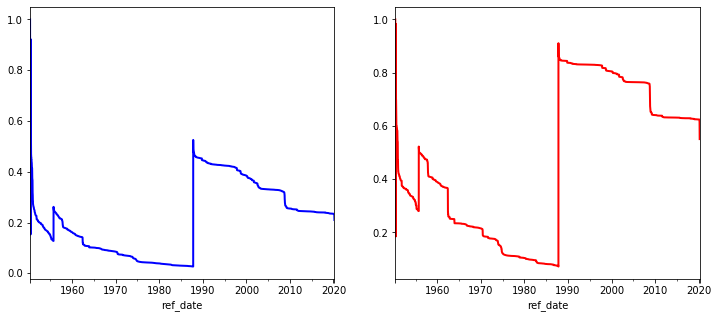

In [14]:
dj_ret_fourth = dj_ret.dropna()**4
dj_ret_third = dj_ret.dropna()**3

max_to_sum_third = abs(dj_ret_third).expanding().max() / abs(dj_ret_third).expanding().sum()
max_to_sum_fourth = dj_ret_fourth.expanding().max() / dj_ret_fourth.expanding().sum()

fig2 = plt.figure(figsize=(12, 5))
ax3 = fig2.add_subplot(121)
ax4 = fig2.add_subplot(122)
max_to_sum_third.plot(ax=ax3, color='blue', linewidth=2)
max_to_sum_fourth.plot(ax=ax4, color='red', linewidth=2)
plt.show()

## <span style='font-family:Georgia'> Conditional Expectation

Let $K$ be in $R^+$, the relative excess conditional expectation:
$$Phi+ K ≜ E(X)jX>K K$$

We have

for distributions outside the power law basin, and

for distribution satisfying Definition 1. Note the van der Wijk’s law [44],[217].
Figure 10.4 shows the following: the conditional expectation does not drop for large
values, which is incompatible with non-Paretian distributions.

In [15]:
sorted_returns = dj_ret.dropna().sort_values(ascending=False).reset_index().loc[:, index_name]
negative_ret = sorted_returns[sorted_returns < 0]
for i in negative_ret.index:
    print((negative_ret.loc[i:] * -1).mean(), -negative_ret.loc[i])
    

0.006656614559556312 5.255050366193004e-06
0.006657420589550154 7.256319594750593e-06
0.006658226572372837 1.7044077341599184e-05
0.006659031564190417 1.7948157437497336e-05
0.006659836641582435 1.97393837363391e-05
0.006660641697021067 2.1262983709413597e-05
0.006661446762949685 2.384553683487667e-05
0.0066622517109518825 2.700617520745574e-05
0.006663056470871316 2.771561361614161e-05
0.006663861339970936 2.8012534052601623e-05
0.006664666368335115 2.8704733353146494e-05
0.006665471508062727 2.8993310828839824e-05
0.0066662768081716004 2.9538471233214736e-05
0.006667082237581423 3.17604638273572e-05
0.006667887592815523 3.4385281651672095e-05
0.006668692824948464 3.61785338287568e-05
0.006669498034890327 3.7577105065356164e-05
0.006670303270554462 4.115395695303281e-05
0.0066711082674352894 4.227570098402911e-05
0.006671913323612899 4.4002625490091596e-05
0.006672718365602227 4.6794305789021884e-05
0.006673523264054584 4.839717766091933e-05
0.006674328163348278 5.0298060919939935e-05

0.0068603295435138295 0.00024365186418806584
0.006861156421504248 0.0002438575871690496
0.00686198348047617 0.000245486397821737
0.0068628105426115004 0.0002473475232701583
0.00686363757886845 0.00024831721129914275
0.006864464700694853 0.00024856644915371984
0.006865291998212866 0.0002486462973340098
0.006866119492672705 0.00024956326428737796
0.006866947079442984 0.0002503922283323412
0.006867774769566967 0.0002506946864877513
0.0068686026289543145 0.00025123825493522656
0.006869430627499612 0.00025124365609763277
0.006870258832601778 0.0002517535021306916
0.00687108718120384 0.0002543658369138502
0.006871915410186727 0.0002558887385213371
0.0068727436558892385 0.0002606949234807976
0.006873571507239234 0.0002609472649299782
0.006874399534316908 0.0002620239897520582
0.006875227633946786 0.0002625763112404922
0.0068760558718379055 0.00026262228350071304
0.006876884311470668 0.0002628535380087005
0.006877712929708384 0.00026429971587771384
0.006878541574391236 0.0002650689680347984
0.

0.007063587953477991 0.0004972633827260431
0.00706443423838207 0.0004972880454268136
0.007065280738278043 0.000497645752784881
0.007066127410314331 0.0004976981460744767
0.007066974293922407 0.0004982904225998563
0.007067821319566679 0.000500605383254249
0.007068668265134942 0.0005032585994314553
0.007069515086967226 0.0005040936422521236
0.007070362019558134 0.0005058030648931178
0.007071208950141886 0.0005059027124405535
0.007072056086430622 0.0005062197117017275
0.007072903400454977 0.0005082225863218826
0.0070737506746953146 0.0005089799788382532
0.00707459806990583 0.0005092695606813136
0.007075445646527212 0.0005095582446795754
0.0070762934047456545 0.0005101762598679338
0.0070771413021042395 0.0005127989733990646
0.00707798907975227 0.0005133117645995666
0.007078837010172725 0.0005142655435999011
0.007079685036456999 0.0005144812513460106
0.007080533254000296 0.0005163311320715014
0.007081381451716012 0.0005163628060587122
0.007082229864567607 0.0005165106424216415
0.00708307847

0.007276035725168935 0.0007126631330452993
0.007276909443565116 0.0007134463656202072
0.007277783290333583 0.0007138858281895422
0.007278657311300579 0.0007152678435021764
0.007279531381012631 0.0007155706662543837
0.007280405643228235 0.0007157444696810344
0.007281280115210857 0.0007178532502020163
0.007282154539253624 0.0007190432939752078
0.007283029037753993 0.0007209918339838861
0.007283903509662813 0.0007215662287891611
0.007284778138115548 0.0007222650231124561
0.007285652906592621 0.0007227917390192351
0.007286527838090764 0.0007232532978457273
0.007287402941362797 0.0007232851373797367
0.007288278273780983 0.0007233273056058698
0.007289153834059481 0.0007247252083585343
0.007290029441452532 0.0007259528130669768
0.007290905118697515 0.0007260699447380059
0.007291781013984233 0.0007269780357291866
0.007292657021854296 0.000729214911459497
0.007293532965015967 0.0007301268595418797
0.007294409020288988 0.0007339988256021002
0.007295284792575022 0.0007353420608413597
0.0072961606

0.007499815384025738 0.0009424407809598412
0.007500718603668034 0.0009424919748797222
0.007501622065112969 0.000942757687101059
0.007502525738904374 0.0009430880168476152
0.007503429616225864 0.0009431953022789319
0.007504333727900885 0.0009457655972509027
0.00750523773453502 0.0009474223284396954
0.0075061417620241435 0.0009478938807561121
0.007507045973782211 0.0009486493619477177
0.00750795033073365 0.0009491581379994507
0.007508854866962133 0.000950848449385755
0.0075097594195714535 0.0009518729260916681
0.007510664080420328 0.0009546539379475805
0.007511568607205988 0.0009559257871303295
0.00751247320811948 0.0009564386990267293
0.007513377987930284 0.0009574598367865228
0.0075142828765639835 0.000957754268582689
0.007515187974383967 0.0009582780480612563
0.00751609324981215 0.0009595905746880851
0.007516998594009213 0.0009602291956900544
0.007517904100071678 0.0009607973562234529
0.00751880977779873 0.0009619755383364348
0.0075197155429927425 0.0009620062806846574
0.0075206215542

0.007740162403729412 0.0011755172846692474
0.007741100344166483 0.0011765302500127417
0.007742038407912432 0.0011774834468849527
0.007742976603562143 0.0011779656913523118
0.00774391499848956 0.001178297152679586
0.007744853614335996 0.001178718546826163
0.007745792438337641 0.0011801535441874345
0.007746731325638393 0.0011824990145841152
0.007747670146049011 0.0011827548763748696
0.00774860919844061 0.0011832883279225825
0.007749548443200341 0.001184512499074697
0.0077504877815812445 0.0011863392510315096
0.0077514271273927135 0.0011867401566496572
0.007752366684709264 0.0011879244893217011
0.007753306341479289 0.0011890142876634924
0.007754246111279406 0.0011896591169069382
0.007755186057870811 0.0011932792806230719
0.007756125755246902 0.0011947176412859806
0.007757065515790295 0.0011966980901674251
0.007758005261876188 0.001196831915517671
0.007758945258057614 0.0011972202980239377
0.007759885467967348 0.0011981172443303878
0.00776082581881625 0.0011988437518219985
0.00776176633509

0.007981611121314904 0.0014334830277848987
0.007982581789576618 0.0014345858679618573
0.007983552582152099 0.0014351013067785967
0.00798452358619649 0.0014380634861006492
0.007985494438947506 0.0014382432385028343
0.007986465553038346 0.0014389859381447323
0.007987436845074379 0.0014444173864879284
0.007988407619474761 0.001447956366194325
0.007989378156832424 0.0014502056439151811
0.007990348648449061 0.001453195913166061
0.00799131898431596 0.0014550963796984284
0.007992289326151562 0.0014557769443243052
0.007993259855087245 0.001456932294528701
0.007994230500700633 0.0014575160261306452
0.00799520134794177 0.0014621486274078999
0.007996171795464132 0.00146316482551756
0.007997142380365327 0.0014670092243954658
0.00799811268246874 0.00146725644621859
0.00799908323622654 0.001467261722809865
0.008000054077711889 0.001468428781204123
0.0080010250343488 0.0014698755781376027
0.008001996064598014 0.0014706691938057848
0.008002967265619694 0.001471138759294277
0.008003938685683097 0.00147

0.008178250086447214 0.0016378530769378674
0.008179249230506105 0.0016395592864637543
0.008180248419191216 0.0016411777577864939
0.008181247665930428 0.001641268228194659
0.008182247204282518 0.001643036149673427
0.00818324677796864 0.00164340412905295
0.008184246601030698 0.0016437795919652665
0.008185246672438813 0.0016447893100179911
0.00818624689531118 0.0016454490343813521
0.00818724732324953 0.0016464058346518096
0.008188247910902674 0.00164709111943373
0.008189248699885457 0.0016474464579900872
0.008190249740779398 0.0016487088477253886
0.008191250894879955 0.0016494141735865497
0.008192252247508348 0.001649699670060123
0.008193253863028473 0.0016504429249890595
0.008194255671470984 0.0016541667335827626
0.008195257216484442 0.001655814997754801
0.00819625881584403 0.0016570436189832227
0.008197260533858252 0.0016573568227856716
0.008198262510832527 0.0016573669962984816
0.008199264793320197 0.001657600448252472
0.008200267347242812 0.0016596133100987842
0.008201269899976894 0.0

0.008384086028699842 0.0018582745882831375
0.008385114849674209 0.0018588884217428658
0.008386143898306808 0.001863304276813027
0.008387172575111963 0.001864769859379778
0.008388201345256401 0.0018656353848844898
0.00838923030344545 0.0018656431824619624
0.008390259585099123 0.0018660457995081092
0.00839128912806671 0.001866422906914078
0.008392318936498078 0.0018668303988133017
0.008393349005722653 0.0018672475881386097
0.008394379334332945 0.0018673567767798493
0.00839540997108607 0.0018690973274146927
0.008396440658490314 0.001871573175875163
0.00839747128042723 0.0018724210866977176
0.008398502094043933 0.0018776686502230966
0.00839953240427364 0.0018778827146936905
0.008400563006310553 0.0018779752806045158
0.00840159391949622 0.0018790475018735098
0.008402624989116456 0.00187943387569256
0.008403656323679844 0.0018794342902787031
0.008404687984342938 0.0018802003996224448
0.008405719850163706 0.0018810492834913095
0.008406751908146411 0.0018816252771205466
0.008407784201554263 0.

0.008657086657969397 0.0021393027113336682
0.008658158133219542 0.002139861696475509
0.008659229868904638 0.0021412216102482118
0.008660301733443143 0.002141536065414229
0.00866137389884907 0.002141871778116533
0.008662446361774013 0.0021424298493342153
0.008663519085780667 0.0021424392220312782
0.008664592161288936 0.002144108854757243
0.008665665315223519 0.002144526637912314
0.00866673875368892 0.0021479079109552046
0.008667811988928095 0.0021480159389007936
0.008668885559823864 0.002149295259878392
0.00866995927364138 0.0021498061675540026
0.008671033257022386 0.0021504308663428118
0.008672107491353633 0.002151271982243408
0.008673181941099738 0.00215266938401093
0.008674256514691876 0.002153338186889231
0.008675331332283404 0.0021541255728495523
0.008676406374446187 0.002155086403001105
0.008677481612693744 0.0021554257945682886
0.008678557149603066 0.002156197953842587
0.008679632913943452 0.0021567217828899476
0.00868070894679252 0.0021588625027917363
0.008681784981513525 0.0021

0.008949807869647346 0.0024270814048877876
0.008950929383826295 0.0024278768233386705
0.008952051146949337 0.002429645116729162
0.008953172991811777 0.0024296762713025277
0.008954295217292683 0.0024298378680539523
0.008955417801144925 0.0024300610503042996
0.008956540732955428 0.0024300895868846206
0.0089576640464057 0.002430710902222688
0.00895878763964794 0.0024349192100538986
0.00895991089523155 0.002435532665850504
0.00896103443203702 0.0024362255703564983
0.008962158236525773 0.0024366926563733626
0.008963282347736823 0.002437359851808485
0.00896440673135087 0.0024411300646007827
0.008965530852782328 0.0024444358448459935
0.008966654791942606 0.0024452319776054887
0.008967778981360697 0.0024453783577871313
0.008968903533192346 0.0024458163280342005
0.008970028397342227 0.0024468887923345672
0.008971153464538676 0.00244832500886083
0.008972278672138413 0.00245022970903519
0.008973403939385324 0.0024503018129939935
0.008974529582547774 0.0024519230769229905
0.008975655334447259 0.00

0.009225466593019637 0.0027157078237843857
0.009226634262754028 0.0027168145349577566
0.009227802152909716 0.002718200774501134
0.00922897021344774 0.0027202176174092596
0.009230138331286225 0.002724051535557659
0.009231306180289228 0.002724092028578484
0.009232474441357757 0.0027255285584143474
0.00923364286403381 0.002726201002063
0.009234811585632583 0.0027277686852155147
0.009235980445503326 0.0027280994240679313
0.00923714966595274 0.0027289902735988525
0.009238319146526388 0.0027306519252764394
0.009239488748830712 0.0027319474882809835
0.009240658538739132 0.0027356539720834183
0.009241828082889914 0.002736086603088994
0.00924299796986704 0.002738205445625086
0.009244167896580033 0.0027384831113126396
0.009245338194256823 0.002739334770077706
0.009246508759824324 0.002741410940627076
0.009247679373072337 0.0027418630175248815
0.009248850326340072 0.002742445456046849
0.009250021596343725 0.002745175982696968
0.009251192796490223 0.002745547108897406
0.009252364351629355 0.002746

0.009525339756691108 0.0029962546816478808
0.009526566106254415 0.002998222660251293
0.00952779254687925 0.0030008790453769363
0.009529018949265854 0.003001192738594005
0.009530245753665529 0.0030013435102480557
0.009531472990929329 0.0030026923190347166
0.009532700436064108 0.0030043459436944753
0.009533928031869367 0.00300504848144878
0.009535155957306725 0.0030066905003316435
0.009536384035835125 0.0030072782532192255
0.009537612465897705 0.003007848401709312
0.009538841251005757 0.0030079854852763654
0.009540070472870189 0.0030080522357067707
0.00954130014497809 0.0030083600394733567
0.009542530222196224 0.003008362799573505
0.009543760762200483 0.0030120481927710108
0.009544991071593859 0.0030157887692513485
0.009546221139849764 0.003017035838415061
0.009547451436684404 0.003017859421802105
0.00954868204203964 0.00301793185489585
0.009549913097682834 0.0030184825173233953
0.009551144513704772 0.003019381183875347
0.009552376224685317 0.0030205982968192213
0.009553608170729802 0.00

0.009820072983376333 0.0032789266703329156
0.009821358333408371 0.0032794463947761754
0.009822644086540964 0.003279575273706037
0.009823930319844057 0.003280323308665345
0.009825216911863558 0.003281302707841327
0.009826503817311746 0.0032839795964428875
0.009827790702485007 0.00328494224859599
0.009829077904620339 0.0032854592726224707
0.009830365511592398 0.0032876712328767654
0.009831653190057013 0.0032878012405518353
0.009832941349889594 0.0032883418364249017
0.009834229910534103 0.0032883794950724354
0.009835518971269719 0.003288830019416933
0.009836808451071148 0.003289011328816871
0.009838098403222893 0.003290439188667338
0.00983938858237847 0.0032926463555976726
0.009840678835083787 0.003294176145192451
0.009841969294908326 0.0032946825356284792
0.009843260163748879 0.003295641983698472
0.00984455135250456 0.003296188468359773
0.009845842942817014 0.0032970812528908544
0.0098471348666067 0.003299668491249741
0.009848426789727334 0.0033001576974088787
0.009849719126236573 0.0033

0.010151001995241231 0.0035942633026050386
0.010152357253342228 0.0035953296312116745
0.010153712851362103 0.0035958261202623243
0.010155068907344546 0.0035961492561062958
0.010156425457427532 0.0035970958536587494
0.010157782372943415 0.003597321379157692
0.010159139803316636 0.0035983031972758317
0.010160497592349344 0.0035991614701867958
0.01016185576583768 0.0036003050124353564
0.01016321426495847 0.0036010743618172247
0.010164573167402689 0.003601670155009895
0.010165932509368803 0.0036019810895993043
0.010167292350143563 0.0036022765399114087
0.010168652693245558 0.0036065327100185396
0.010170012718112551 0.003609977885982496
0.010171372592663158 0.003610248749251199
0.01017273297496534 0.0036123186187473344
0.010174093492251988 0.003613166318093497
0.010175454398116776 0.0036134836003436366
0.010176815802846604 0.0036153534481132565
0.010178177384576161 0.003615579953506809
0.010179539484499588 0.003619763512557328
0.010180901281462831 0.0036208376064799097
0.010182263420930229 

0.01050493854117822 0.003937495225007304
0.010506371229510718 0.00394009795303274
0.010507803975152542 0.003940363347962328
0.010509237288253197 0.003941381461811222
0.010510671004871063 0.003942347115778899
0.010512105136724575 0.0039432176656151174
0.010513539704855412 0.003943426989724386
0.010514974853984973 0.003943692097910678
0.010516410572306163 0.003946755295557547
0.010517846248721536 0.0039484898524475565
0.010519282173616896 0.003949492477900107
0.010520718507175206 0.003949877417597558
0.01052215538473689 0.003949895421075933
0.010523592886916169 0.003956805662590046
0.01052502950630456 0.003958029367025717
0.010526466486641382 0.003959205671406729
0.010527903838537907 0.0039629218515705444
0.010529341006223322 0.003963019335926576
0.010530778781933918 0.003963508998415355
0.010532217080178229 0.003963601180339338
0.010533655988370963 0.003963812721507143
0.010535095480760722 0.0039643925469421415
0.010536535477020601 0.003966254144466053
0.010537975696514804 0.00396990859

0.01081051170893768 0.004266296259549662
0.010812007529611823 0.004266592680814196
0.01081350396647712 0.004266778029664908
0.01081500104535588 0.004267807760234055
0.01081649857355467 0.004269153342434717
0.010817996479121158 0.004269723429626504
0.010819494939773215 0.004270670429624479
0.010820993869622186 0.004270878141707124
0.010822493438241213 0.004271333579608516
0.010823993589342346 0.004272061306281771
0.010825494260960088 0.004272798579862069
0.010826995451265036 0.004273432731553672
0.010828497184243889 0.0042739290328993595
0.010829999491865102 0.004274422088704766
0.010831502375267935 0.004275307540234752
0.010833005744870096 0.004275385827501532
0.010834509786135548 0.004278943210743513
0.010836013701385698 0.004281432919690964
0.010837517735525598 0.004282061872918463
0.010839022315709811 0.00428258663961123
0.01084052746623233 0.004282619838947066
0.010842033300360293 0.004285306514333231
0.010843539209130625 0.0042876216037962545
0.01084504527795795 0.0042894637488002

0.011151373247820971 0.004547990371753019
0.011152962892230233 0.004549305028505479
0.011154552985623855 0.004549760944763892
0.011156143735152002 0.0045501133645993175
0.011157735166221757 0.004550625711035261
0.011159327240789272 0.004552097027575419
0.011160919728187007 0.004552677284653028
0.011162512843530193 0.004553562624931562
0.011164106513705889 0.004557825058304377
0.011165699924573084 0.004561622912673258
0.011167293188025895 0.004562159422126455
0.011168887090961683 0.004563766838725947
0.011170481375357592 0.004565556947304428
0.011172075997382711 0.004566252447143815
0.011173671221616045 0.004566400620637623
0.011175267180698407 0.004567071789839172
0.011176863748804439 0.004569553143145666
0.011178460488921805 0.004570490290882079
0.011180057774442238 0.004570782524428552
0.011181655761688374 0.004570862130682585
0.011183254502590674 0.004574428196475355
0.011184853154333808 0.004575153116872177
0.011186452404282381 0.0045788755338351805
0.011188051527435926 0.004583623

0.011562679831713848 0.004962031830688551
0.011564371004658 0.004963663787193262
0.011566062626189899 0.004966504966504859
0.011567754386676872 0.004966546593757282
0.011569447004059671 0.004967777310013521
0.011571140174024802 0.004968365485385928
0.011572834061836151 0.0049683752923030955
0.0115745288164601 0.004969879518072484
0.011576224054986381 0.0049719865871989954
0.011577919623014056 0.0049726400765661705
0.01157961589408402 0.0049727569059460075
0.011581313006590606 0.004976092016230393
0.011583010134285969 0.004976376511502845
0.011584708061200077 0.004977293369663904
0.011586406625388132 0.004977602737389231
0.011588105983549098 0.004978864611388523
0.011589805891309427 0.004980483601155883
0.01159150625721891 0.004982038749190121
0.011593207098059886 0.004982729477474801
0.011594908636700962 0.004983199793228255
0.011596610930429971 0.0049851616598114434
0.011598313595706978 0.004985686696160729
0.011600017002945398 0.004986118193665345
0.011601721176820502 0.0049864918326

0.011953973147952707 0.0053158748810923084
0.011955777469308202 0.005317792037047964
0.011957582250556776 0.005320005420442975
0.011959387411511391 0.005320767904045898
0.011961193347177185 0.005322582131935594
0.011962999771997657 0.005322693617588414
0.011964807149829561 0.005323149916102499
0.011966615387573567 0.005328260917929151
0.011968423218311486 0.005332818551452179
0.011970230792451192 0.0053338745118897135
0.011972039063917288 0.005337163900025921
0.01197384742455067 0.005337163945530521
0.011975656771191626 0.005339069102184735
0.011977466585118269 0.005343175892802976
0.01197927626615818 0.005345064305528391
0.01198108641948987 0.005352599286887583
0.01198289550440597 0.005352944119265568
0.011984705482944093 0.005353626971661085
0.011986516263531552 0.00535406074980338
0.011988327914860078 0.005355264416180505
0.011990140227291411 0.005356728599447469
0.011991953130168657 0.005358299475946571
0.011993766594808958 0.005359662165050905
0.01199558067860162 0.005359818896657

0.0124086100736077 0.005780477852835864
0.012410539660862654 0.005784686037269227
0.012412469146483968 0.0057859711465267916
0.012414399381846613 0.005788450842802995
0.012416330019532816 0.005789069716010453
0.01241826160225025 0.005789355582301536
0.012420194227912044 0.005790244006842138
0.012422127721706464 0.005793219478657741
0.012424061475569667 0.005795363260616915
0.01242599573241675 0.00579619669611986
0.012427930875159391 0.0057981232070792865
0.012429866585427442 0.005798768374591257
0.01243180323794229 0.00579936841483919
0.012433740846713282 0.00580116716019885
0.012435679062285026 0.005805582843832924
0.012437617120226696 0.005805858453660218
0.012439556230947916 0.005806053119209453
0.012441496419047281 0.005806129119083292
0.01244343772018829 0.005808847817855178
0.01244537936195075 0.0058093892290783655
0.012447321982013069 0.0058116440658285695
0.012449265079499507 0.005812012187487059
0.012451209207470218 0.005812056448323721
0.01245315446172136 0.005823946903185884

0.012952294078425384 0.006313148909483646
0.012954391754624102 0.006320628232139525
0.012956488392905542 0.0063216988040029065
0.012958586018447403 0.0063224725541201066
0.01296068472605788 0.00632364184607459
0.012962784391632058 0.006325240568506696
0.012964884880183682 0.0063261511538882376
0.012966986410328125 0.006327172329166353
0.012969088948035903 0.006329996374892066
0.012971191923193692 0.00633210968644482
0.012973295561418265 0.006334573382135944
0.012975399752283331 0.006342225196800277
0.012977502851381453 0.00634459562757983
0.01297960653270838 0.00634558892710424
0.012981711233725388 0.006348140455535778
0.012983816460884447 0.00635052741331954
0.012985922266931293 0.006350945239751882
0.012988029277737 0.006351089066206628
0.012990137581489076 0.006354525300613978
0.012992246133214804 0.0063548518688493205
0.012994355921601444 0.006354894831699487
0.012996467038005227 0.006354981505063417
0.012998579469790512 0.006355402091778095
0.01300069311197251 0.006356791196061362

0.013508046967235527 0.006866373793628089
0.013510328545103478 0.006867930839831948
0.013512611155998762 0.006868429022627964
0.013514895164982386 0.00687144946763274
0.01351717970614379 0.006873103498702182
0.013519465250074797 0.006873319593668659
0.013521752292626898 0.006873983424986574
0.013524040681221608 0.0068740482923644874
0.013526330623504274 0.006875944577117821
0.013528621490209884 0.0068818198835045585
0.013530911911163264 0.006881845497722305
0.013533203902343352 0.006884515857254692
0.013535496553393382 0.006885748784387968
0.013537790360833538 0.006887300538571006
0.013540085215844672 0.006888070100618426
0.013542381389512333 0.006891225568823045
0.01354467805933992 0.006891458278213802
0.013546976235430117 0.006894048518578555
0.013549275104717214 0.0068943089430894
0.013551575473248713 0.006894422058719374
0.01355387739351653 0.006895563922082237
0.013556180511285968 0.006895705247654038
0.013558485174006946 0.006897043784336643
0.013560790968880491 0.006897479896369

0.01409155794875308 0.007373883461800013
0.01409407581775119 0.007374812009134923
0.014096595226753297 0.007378911918517028
0.014099114987934178 0.007378995433789837
0.014101636608780008 0.007380592146357001
0.014104159523368008 0.007383329255179483
0.014106683304918212 0.007385177092121165
0.014109208288469227 0.007394378597765927
0.014111731711877979 0.0073982432265247144
0.014114255579729618 0.007399658646699336
0.014116780813626956 0.007399719152573536
0.014119307924861364 0.007399993394027193
0.014121836835110082 0.0074003031982299294
0.014124367533015535 0.00740881458966558
0.014126896931487607 0.007409580166301111
0.014129427947601088 0.007410983390524817
0.014131960342835571 0.007414266267265268
0.014134493409983219 0.007414460398379896
0.014137028314929127 0.007420854440860047
0.014139562720164629 0.007420885511434605
0.01414209902715169 0.007421925665451301
0.014144636856971062 0.007422110986450292
0.014147176534292753 0.007422341962995516
0.014149718043956889 0.0074236433952

0.014848455166509768 0.008064934840172344
0.014851299409833178 0.008065698098928209
0.014854145719107884 0.008065881322007917
0.01485699434034041 0.008076569503878583
0.0148598408663003 0.008081400217737289
0.014862687754434936 0.008081513015562924
0.014865536987518493 0.008089934860264658
0.014868385075844372 0.008090512609822409
0.01487123531657861 0.008099291908664208
0.014874084262059432 0.008099668206362653
0.014876935447268057 0.008101779255263564
0.014879788144612062 0.00810633672229688
0.01488264132549762 0.008107069278910028
0.014885496602381983 0.008107599108572172
0.014888354063382746 0.008113088939444957
0.01489121161931861 0.008114424912765705
0.014894071022992263 0.00811567020295334
0.014896932315022671 0.008123476848090894
0.014899792726959722 0.008124269553278607
0.014902655220907194 0.00812470129774645
0.014905519952066603 0.008128469468675625
0.014908385512524698 0.008129131424173708
0.0149112532172998 0.00812915282392035
0.014914123340191628 0.008129648743841589
0.01

0.015670352128870788 0.008773748943162074
0.015673612934159538 0.008775336987326132
0.015676876073207235 0.008782937722413786
0.01568013870375659 0.008784016534619354
0.015683403913116983 0.008784335491170303
0.01568667206490379 0.008784460535605776
0.01568994325520203 0.008785114335088218
0.015693217237620294 0.008786483770710118
0.015696493676646342 0.008786503573698479
0.015699773216325007 0.00879448532428806
0.015703052080471274 0.008796743213649427
0.01570633298729637 0.008804387796555457
0.015709613379497292 0.008811207526582931
0.015712893648566675 0.008819285773803531
0.015716173195605098 0.008819981122364928
0.015719455533574275 0.008820597032432098
0.0157227407042891 0.008821157047486872
0.015726028738427645 0.00882141956997995
0.01572931978188258 0.008822459374241975
0.015732613468295378 0.00882804999045217
0.015735907630259997 0.00882896925564447
0.01573920449821924 0.008836150737108195
0.01574250108549771 0.00884172482782164
0.0157457981596772 0.008842366117404743
0.015749

0.01664027277788648 0.00958721251433925
0.016644105962812322 0.009589875179402463
0.01664794186862168 0.009591584158415878
0.016651781018627233 0.00959179616846706
0.016655624233025794 0.00959658321104595
0.01665946902661075 0.009600230196255444
0.016663316023248546 0.009600436956430425
0.016667167102347138 0.009609379721589817
0.016671017504627968 0.009613299602457603
0.01667486997073177 0.009618462535642025
0.016678723825147443 0.009622958449427732
0.01668257943464237 0.009631399811717012
0.016686434644933745 0.009634599914201791
0.016690292322576374 0.009643302743735371
0.016694149459729548 0.009644031514135065
0.016698010422459882 0.009645147687871392
0.016701875004780205 0.009646140013311322
0.016705743280543073 0.009648257404079041
0.016709614638676075 0.00964999502833852
0.016713489292688333 0.00965134239366594
0.016717367462319867 0.009652865806121458
0.016721249056636463 0.009657111423507114
0.016725132584747032 0.009659473008497899
0.016729019086164112 0.009669762100166124
0.

0.01760539037431848 0.010363407008355585
0.01760989689788162 0.010367128511228452
0.017614406716304196 0.01038195060766367
0.01761891291948715 0.010390851273476498
0.01762341919233379 0.010397403774528469
0.017627926999830863 0.010402044052151727
0.017632437538499825 0.01041220098329565
0.017636947367703576 0.01042924951208124
0.017641452178863343 0.010429903363163628
0.01764596221564614 0.010431083955035003
0.01765047715823726 0.010433195810853668
0.017654996432719026 0.010441211892718405
0.017659516347844344 0.010447676915534276
0.017664037877268987 0.010450022572920492
0.017668563608325666 0.010450480206016355
0.0176730947341275 0.010452200404479695
0.01767763047177175 0.010452262203227924
0.01768217187231766 0.010452878708510083
0.01768671859757792 0.01045741799578681
0.017691268188894337 0.01045779417274284
0.017695823273287378 0.0104583767764308
0.017700383731067377 0.010468544253705803
0.017704943528972394 0.01047431482357597
0.017709505439827532 0.010479129237732976
0.017714070

0.01892655007914219 0.011496060564576083
0.018932086956574803 0.011497494617894066
0.01893763102245003 0.011502084830461778
0.018943179937518675 0.011505428617728075
0.018948734643508065 0.01151830053338232
0.018954288032230135 0.011518787031244426
0.01895984936431763 0.011537691721415166
0.018965404871535377 0.011540058115400598
0.018970966929030608 0.011542091355228434
0.018976535801274834 0.01154508902929341
0.018982110780098527 0.011547329839292075
0.018987692447471505 0.011562853038462828
0.01899327083921381 0.011562866175852893
0.01899885760963739 0.011563588089387844
0.019004452244340362 0.011566621354129447
0.019010053020613114 0.011569719123708633
0.019015659903730598 0.011583938539103222
0.019021264520144347 0.011587858499372272
0.01902687463789587 0.011588347863066173
0.01903249286053547 0.011598107216891584
0.019038112199646313 0.01159830153131891
0.01904373989304142 0.01159869736770991
0.019049375807140837 0.01160166904877824
0.019055018009230505 0.011613672021324462
0.019

0.020562029431817886 0.01285552665872014
0.020569158481561725 0.012865915437038411
0.020576291114010357 0.012867213232502617
0.02058343576450295 0.012877910716583063
0.020590583746922173 0.012890161786227261
0.020597733628037025 0.012904169198304727
0.02060488378085276 0.012908381971858396
0.020612043317419268 0.01291043878882836
0.020619214271356504 0.012932421394803884
0.020626378104419463 0.012936419926539933
0.02063355157286897 0.012939487179487119
0.020640735573236275 0.012942673925315784
0.02064793002337452 0.012942782378709272
0.020655137832209566 0.012946650453722786
0.020662355517020878 0.012971366836291853
0.020669563566393635 0.012988035264483666
0.020676769502886983 0.012997685202260856
0.020683979910681 0.013015409375939813
0.02069118721381515 0.013030241065139836
0.020698394124585306 0.013034882979401696
0.02070561023677475 0.013043352934394181
0.020712831968445228 0.0130439601997836
0.02072006675313265 0.01304950061966903
0.020727309969500417 0.013054940419698458
0.02073

0.022391528756751437 0.01434517705254268
0.02240093969441718 0.014347896179268127
0.02241036948776044 0.014352439688010254
0.022419816064313487 0.014354185280416876
0.022429282767111494 0.014356345163391682
0.022438769180276853 0.014356713885593675
0.022448277480623533 0.01435871349626594
0.022457805824539153 0.014378191860874745
0.022467333671194422 0.01439061540909814
0.022476869348009174 0.014392419292145076
0.02248642543554566 0.014392902585161127
0.022496003569096413 0.014397318794401648
0.0225055991671707 0.014401478838424131
0.022515212595793175 0.014402437890181807
0.02252484772014663 0.014439647030850433
0.02253446151406969 0.014441857149646076
0.022544095566884484 0.014458664050655434
0.02255373255319703 0.014461041977360978
0.022563389701855546 0.014462524345039918
0.0225730681550895 0.014463226945881313
0.022582768922086164 0.014473108681382185
0.0225924810900391 0.01448267825066607
0.02260220507425897 0.014490142266969541
0.022611943444976 0.0144939823072332
0.022621700609

0.025469947605842782 0.016535386884985126
0.025484988953857698 0.01654134983641853
0.025500070975978166 0.016547242755858838
0.02551519399662026 0.016549635624662273
0.025530364146149797 0.016552998724374546
0.025545580019746033 0.01655843051919348
0.025560838338083133 0.016569842656579348
0.025576129147065283 0.016574182387021463
0.025591464661136907 0.016579429242675414
0.02560684356116841 0.016584437971824295
0.02562226647670575 0.016590614178953578
0.025637731634749847 0.016600939360021716
0.025653232136078712 0.016603395325029746
0.025668781683864023 0.016634102550562413
0.02568433190612444 0.016634460740776236
0.02569993513227159 0.016659980649880834
0.025715548179736866 0.016660129620290953
0.025731214993853554 0.016690166477608015
0.025746884055406837 0.016694288292752435
0.02576260036749478 0.016699327229314
0.02577836258164814 0.016702387111078187
0.025794174385603837 0.01672116078519903
0.025810008615272953 0.016751997820058873
0.025825844298481365 0.016761532312366656
0.025

0.0313502585100669 0.020916796259487835
0.031382863079599956 0.020992879805281195
0.031415433560083715 0.02099470317121821
0.031448203152501526 0.021001782439100003
0.03148115716106115 0.021003320683111948
0.03151431487143441 0.021019512453069766
0.031547631704508576 0.021031926161295234
0.031581121212607983 0.021058640315075428
0.03161473936244035 0.021073552814357188
0.031648525216761134 0.021089957511074675
0.031682475595236015 0.021095831761417827
0.031716626059216074 0.021171438754900906
0.031750752878971125 0.02117630253901348
0.03178508550994502 0.021205290231297802
0.031819547383816836 0.021222100256128695
0.031854179563972684 0.021253571764635715
0.031888935655118036 0.021266325541495767
0.03192387845154444 0.02131662049324834
0.03195888590355201 0.021325452542576895
0.031994095947793656 0.021337716030989218
0.03202949920333121 0.02134550725627704
0.032065112509821386 0.021349482926461216
0.032100950735852694 0.021382006009124988
0.03213692034902963 0.021437254988327492
0.0321

0.046983948101398255 0.03095402239277656
0.04714920506746653 0.030961570654872927
0.047317826259264374 0.030991999319091135
0.04748967706916094 0.03106695174485008
0.04766438691303659 0.031309805779251576
0.047840242624152554 0.03131889809464139
0.04801982245599507 0.031426974946010766
0.04820216143962127 0.031452685159114924
0.0483882667316269 0.0314725573327862
0.04857833088217567 0.031525628030572794
0.04877211159639843 0.03156393363350252
0.04896990674539723 0.03165972049510002
0.049171187980865796 0.031721985799831987
0.04937647271240737 0.031879973810319484
0.04958476436600366 0.03198308185805965
0.0497968328299548 0.032079351483830454
0.05001289967563924 0.032165415727059665
0.0502332389836464 0.03240281540478429
0.05045611927838217 0.03253474379669852
0.050682972132580696 0.032548254220435835
0.05091546851606973 0.03268383582302803
0.05115224296662872 0.032933658998715365
0.05139196117673284 0.03388598876878779
0.05162537414217211 0.03401639344262286
0.051863333340814666 0.0340